In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import diffxpy.api as de
import scanpy as sc

In [5]:
with open('../../path.to.data.txt', 'r') as file:
    prefix = file.readline().strip()

In [9]:
def get_grid_to_celltype(data, celltype):
    '''
    Return a dictionary that maps the gridpoints to whether or not 
    they have a celltype in that gridpoint.
    '''
    grid_to_celltype = defaultdict(bool)
    for k, v in zip(zip(data.obs.X, data.obs.Y), (data.obs.celltype == celltype)):
        if v:
            grid_to_celltype[k] = True 
    return grid_to_celltype


def add_celltype_columns(data):
    '''
    Adds columns to data that says whether or not a particular celltype exists
    at a gridpoint
    '''
    immune_cells = set(['Marcrophage', 'Lymphocyte'])
    data.obs["Is_Immune"] = data.obs.celltype.map(lambda x: x in immune_cells)
    grid_to_has_immune = (data.obs.groupby(["X", "Y"]).Is_Immune.sum() > 0).to_dict()
    data.obs["Has_Immune"] = [grid_to_has_immune[k] for k in zip(data.obs.X, data.obs.Y)]

    grid_to_has_macrophage = get_grid_to_celltype(data, 'Macrophage')
    data.obs["Has_Macrophage"] = [grid_to_has_macrophage[k] for k in zip(data.obs.X, data.obs.Y)]

    grid_to_has_lymphocyte = get_grid_to_celltype(data, 'Lymphocyte')
    data.obs["Has_Lymphocyte"] = [grid_to_has_lymphocyte[k] for k in zip(data.obs.X, data.obs.Y)]

    grid_to_has_kupffer = get_grid_to_celltype(data, 'Kupffer')
    data.obs["Has_Kupffer"] = [grid_to_has_kupffer[k] for k in zip(data.obs.X, data.obs.Y)]
    return data

def add_hex_coords(data):
    '''
    Adds the hexagonal grid coordinates from the (X,Y) coordinates provided
    '''
    x = data.obs.X 
    y = data.obs.Y - (data.obs.X % 2) / 2
    data.obs["X_hex"] = x
    data.obs["Y_hex"] = y
    return data 


def load_data_for_notebook():
    data = sc.read(prefix + 'old_directories/20200327/concat_20200311.loom')
    data.obs.rename({"CellType": "celltype"}, axis=1, inplace=True)
    
    # keep only mouse genes
    genes_to_keep = data.var.index[data.var.index.map(lambda x: x.startswith('mm'))]
    data = data[:, genes_to_keep].copy()
    # Remove log transformation 
    data.X = np.exp(data.X.todense()) - 1
    data.X = scipy.sparse.csr_matrix(data.X)

    data = add_grid_data(data)
    data = add_celltype_columns(data)

    return data

def add_grid_data(data):
    df = pd.read_csv(prefix + 'plate23_map.csv', header=None)
    df.columns=["barcode", "X", "Y"]
    barcode_to_xy = {}
    for b, x, y in df.to_numpy():
        assert(b not in barcode_to_xy)
        barcode_to_xy[b] = (x,y)
    data.obs['X']= data.obs.barcode.map(lambda b: barcode_to_xy[b][0])
    data.obs['Y']= data.obs.barcode.map(lambda b: barcode_to_xy[b][1])
    data = add_hex_coords(data)
    return data


def filter_genes_mincount_hepatocytes(data, count_min=100):
    '''
    Filter gene if it does not have `count_min` counts among hepatocytes
    '''
    row_inds = data.obs[data.obs.celltype == "Hepatocyte"].index
    gene_has_counts = np.asarray(data[row_inds,:].X.todense().sum(axis=0) > count_min).reshape(-1)
    genes_to_keep = data.var.index[gene_has_counts]
    data = data[:, genes_to_keep].copy()
    return data


def normalize_data(data):
    median_reads = data.obs.n_counts.median()
    sc.pp.normalize_total(data, target_sum=median_reads)
    return data

In [13]:
def subselect_data(data, celltype, grouping_fn):
    '''
    Returns a subselection of the data with a particular celltype and grouping
    function
    '''
    data_cell = data[data.obs.loc[data.obs.celltype == celltype].index].copy()
    grouping = grouping_fn(data_cell)
    data_cell.obs["grouping"] = grouping
    return data_cell


def plot_grouping(cell_spec_data, data, layer, perc):
    '''
    Plots the hexagonal grid colored by grouping labels
    '''

    perc_label = int(100*perc)
    blue_label = f"Percent Tumor Within {layer} layers > {perc_label}%"
    red_label = f"Percent Tumor Within {layer} layers < {perc_label}%"



    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    ax1 = axes[0]
    ax2 = axes[1]

    sub_df = cell_spec_data.obs.loc[~cell_spec_data.obs.grouping]
    x = sub_df.X 
    y = sub_df.Y - (sub_df.X % 2) / 2
    red_sc = ax1.scatter(x,y, c="Red", cmap='bwr', marker='H',s=20*10, label=red_label)
    sub_df = cell_spec_data.obs.loc[cell_spec_data.obs.grouping]
    x = sub_df.X 
    y = sub_df.Y - (sub_df.X % 2) / 2
    blue_sc = ax1.scatter(x,y, c="Blue", cmap='bwr', marker='H',s=20*10, label=blue_label)
    ax1.set(xlim=(0,42), ylim=(0,20))
    ax1.invert_yaxis()
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], fontsize=15)
    #ax1.legend(, fontsize=15)



    sub_df = data.obs.loc[data.obs.celltype=='Hepatocyte']
    x = sub_df.X 
    y = sub_df.Y - (sub_df.X % 2) / 2
    ax2.scatter(x,y, c="Red", marker='H',s=20*10, label="Hepatocyte")

    sub_df = data.obs.loc[data.obs.celltype=='mc38']
    x = sub_df.X 
    y = sub_df.Y - (sub_df.X % 2) / 2
    ax2.scatter(x,y, c="Blue", marker='H',s=20*10, label='Cancer')

    ax2.set(xlim=(0,42), ylim=(0,20))
    ax2.invert_yaxis()
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[::-1], labels[::-1], fontsize=15)
    return fig


def perform_mann_whitney(hepatocytes, all_genes):
    '''
    Runs and plots results of mann_whitney test
    '''
    mann_whitney = de.test.rank_test(hepatocytes, grouping="grouping")
    idxs = np.argsort(mann_whitney.pval)
    pvals_sorted = mann_whitney.pval[idxs]
    qvals_sorted = mann_whitney.qval[idxs]
    genes_sorted = mann_whitney._gene_names[idxs]
    fc_sorted = mann_whitney.log2_fold_change()[idxs]
    genes_to_write = [x[5:].upper() for x in genes_sorted]
    genes_to_write_set = set(genes_to_write)
    other_genes = [x[5:].upper() for x in all_genes if x[5:].upper() not in genes_to_write_set]
    df = pd.DataFrame(list(zip(genes_sorted, pvals_sorted, qvals_sorted)), columns=["Gene", "Pval", "Qval"])

    #mann_whitney.plot_volcano(corrected_pval=True, size=40, save=save)

    # idxs = np.argsort(mann_whitney.pval)
    # pvals_sorted = mann_whitney.pval[idxs]
    # genes_sorted = mann_whitney._gene_names[idxs]
    # fc_sorted = mann_whitney.log2_fold_change()[idxs]


    # mean_blue_label = np.mean(np.asarray(hepatocytes[hepatocytes.obs.grouping].X.todense()[:, idxs[0]]).reshape(-1))
    # mean_red_label = np.mean(np.asarray(hepatocytes[~hepatocytes.obs.grouping].X.todense()[:, idxs[0]]).reshape(-1))


    # median_blue_label = np.median(np.asarray(hepatocytes[hepatocytes.obs.grouping].X.todense()[:, idxs[0]]).reshape(-1))
    # median_red_label = np.median(np.asarray(hepatocytes[~hepatocytes.obs.grouping].X.todense()[:, idxs[0]]).reshape(-1))

    # y = np.asarray(hepatocytes.X.todense()[:, idxs[0]]).reshape(-1)
    # x = hepatocytes.obs.grouping
    #ax = sns.boxplot(x,y)

    # print(f"1.  {genes_sorted[0][5:]}, Fold Change: {fc_sorted[0]:.2f}")
    # print(f"2.  {genes_sorted[1][5:]}, Fold Change: {fc_sorted[1]:.2f}")
    # print(f"3.  {genes_sorted[2][5:]}, Fold Change: {fc_sorted[2]:.2f}")
    # print(f"4.  {genes_sorted[3][5:]}, Fold Change: {fc_sorted[3]:.2f}")
    # print(f"5.  {genes_sorted[4][5:]}, Fold Change: {fc_sorted[4]:.2f}")
    # print(f"5.  {genes_sorted[5][5:]}, Fold Change: {fc_sorted[5]:.2f}")
    # print(f"6.  {genes_sorted[6][5:]}, Fold Change: {fc_sorted[6]:.2f}")
    # print(f"7.  {genes_sorted[7][5:]}, Fold Change: {fc_sorted[7]:.2f}")
    # print(f"8.  {genes_sorted[8][5:]}, Fold Change: {fc_sorted[8]:.2f}")
    # print(f"9.  {genes_sorted[9][5:]}, Fold Change: {fc_sorted[9]:.2f}")
    # print(f"10. {genes_sorted[10][5:]}, Fold Change: {fc_sorted[10]:.2f} ")
    # print(f"11. {genes_sorted[11][5:]}, Fold Change: {fc_sorted[11]:.2f}")

    # print()
    # print(f"Mean Expression {blue_label}: {mean_blue_label:.2f}")
    # print(f"Mean Expression {red_label}: {mean_red_label:.2f}")
    # print()
    # print(f"Median Expression {blue_label}: {median_blue_label:.2f}")
    # print(f"Median Expression {red_label}: {median_red_label:.2f}")

    return mann_whitney, df



def get_nbr_coords(center):
    '''
    Get coordinates of the first layer around a cell
    '''
    x, y = center
    nbrs = [(x, y+1), (x, y-1), (x+1, y+0.5), (x+1, y-0.5), (x-1, y+0.5), (x-1, y-0.5)]
    return set(nbrs)

def get_layer_coords(center, max_layer):
    '''
    Get all points within a particular layer
    '''
    if max_layer == 0:
        return [center]
    total = get_nbr_coords(center) 
    layer_points = total.copy()
    if max_layer==1:
        return layer_points
    for layer in range(2, max_layer+1):
        next_layer = set([nbr for point in layer_points for nbr in get_nbr_coords(point)])
        total.update(x for x in next_layer)
        layer_points = next_layer
    return total



def get_average_stats(data, nbrs, celltypes):
    num_cells = 0
    num_celltypes = 0
    for nbr in nbrs:
        sub_df = data.obs.loc[data.obs.Grid_Point == nbr]
        num_cells += sub_df.shape[0]
        celltype_series = [sub_df.celltype == celltype for celltype in celltypes]
        num_celltypes += pd.DataFrame(celltype_series).sum().sum()
    if num_cells == 0:
        return 0.0
    return num_celltypes / num_cells


def get_in_well_stats(data, nbrs, celltypes):
    num_wells = 0
    num_has_celltypes = 0
    for nbr in nbrs:
        sub_df = data.obs.loc[data.obs.Grid_Point == nbr]
        num_wells += 1
        celltype_series = [sub_df.celltype == celltype for celltype in celltypes]
        num_celltypes = pd.DataFrame(celltype_series).sum().sum()
        num_has_celltypes += 1 if num_celltypes > 0 else 0
    return num_has_celltypes / num_wells


def add_tumor_spatial_data(data):
    data.obs["Grid_Point"] = data.obs.loc[:, ["X_hex", "Y_hex"]].apply(lambda row: (row[0], row[1]), axis=1)
    max_layers = 2
    batch_dfs = []
    for batch in tqdm(range(5), total=5, desc="Processing Tumor Spatial Information"):
        sub_data = data[data.obs[f'batch_{batch}'] == 1].copy()
        sub_df = data.obs.loc[data.obs[f'batch_{batch}'] == 1].copy()

        grid_points = sub_df.Grid_Point.unique()
        grid_to_layer_to_percent_tumor = defaultdict(dict)
        for layer in range(max_layers):
            for grid_point in grid_points:
                nbrs = get_layer_coords(grid_point, layer)
                percent_tumor = get_average_stats(sub_data, nbrs, celltypes=['mc38'])
                grid_to_layer_to_percent_tumor[grid_point][layer] = percent_tumor

        for layer in range(max_layers):
            sub_df[f"Percent_Tumor_{layer}"] = sub_df.Grid_Point.map(lambda x: grid_to_layer_to_percent_tumor[x][layer])

        grid_to_layer_to_wells_with_tumor = defaultdict(dict)
        for layer in range(max_layers):
            for grid_point in grid_points:
                nbrs = get_layer_coords(grid_point, layer)
                percent_tumor = get_in_well_stats(sub_data, nbrs, celltypes=["mc38"])
                grid_to_layer_to_wells_with_tumor[grid_point][layer] = percent_tumor

        for layer in range(max_layers):
            sub_df[f"Percent_Wells_With_Tumor_{layer}"] = sub_df.Grid_Point.map(lambda x: grid_to_layer_to_wells_with_tumor[x][layer])
        batch_dfs.append(sub_df)

    df = pd.concat(batch_dfs)
    new_columns = [c for c in df.columns if c not in data.obs.columns]
    data.obs = data.obs.merge(df.loc[:,new_columns], how='outer', left_index=True, right_index=True)
    return data

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data = load_data_for_notebook()
all_genes = np.asarray(data.var.index)

data = load_data_for_notebook()
# Remove all genes for which hepatocytes have fewer than count_min counts
data = filter_genes_mincount_hepatocytes(data, count_min=100)

# should we normalize the counts??
normalize = True
data = normalize_data(data) if normalize else data


/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


In [14]:
# add data describing percentage of tumor cells within different layers around each grid cell
data = add_tumor_spatial_data(data)

Processing Tumor Spatial Information: 100%|██████████| 5/5 [00:41<00:00,  8.24s/it]


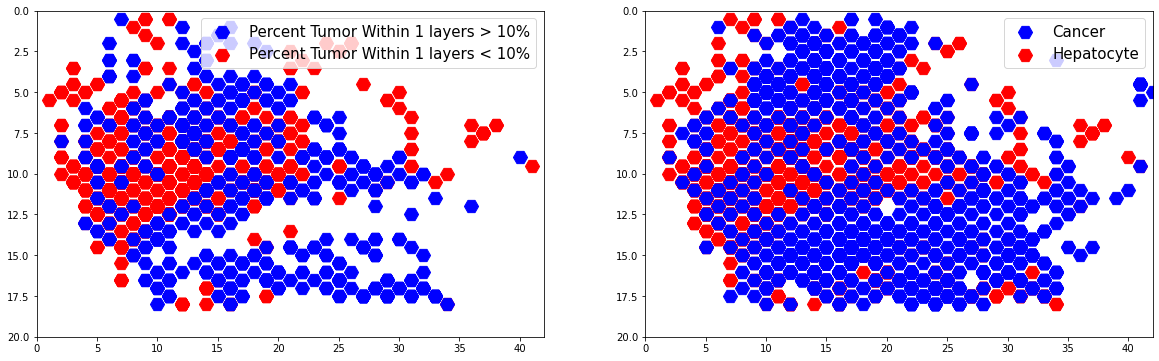

In [15]:
# Define layer and percentage cutoff
layer = 1
perc = 0.1

# Split grid cells based on cutoff
grouping_fn = lambda data: ((data.obs[f'Percent_Tumor_{layer}'] > perc))
hepatocytes = subselect_data(data, 'Hepatocyte', grouping_fn)
fig = plot_grouping(hepatocytes, data, layer, perc)

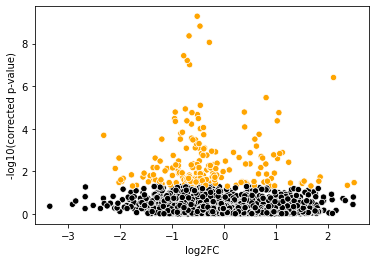

In [16]:
# Perform Mann Whitney test and plot results
test, results = perform_mann_whitney(hepatocytes, all_genes)
test.plot_volcano(corrected_pval=True, size=40, save=None)

In [17]:
results.head()

,Gene,Pval,Qval
0,mm10_Cps1,1.134813e-13,5.186095e-10
1,mm10_Dpyd,6.614645e-13,1.511446e-09
2,mm10_Hnf1aos1,2.855321e-12,4.349606e-09
3,mm10_Malat1,7.645244e-12,8.734691e-09
4,mm10_Slc7a2,4.057121e-11,3.708208e-08
